In [644]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt

In [625]:
datafile = "./data/2025-07-01_full_training_data_99993_samples.csv"

In [626]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Mac Metal Performance Shaders
    print(f"Training on device: {device} (Mac GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Training on device: {device} (NVIDIA GPU)")
else:
    device = torch.device('cpu')
    print(f"Training on device: {device} (CPU)")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

Training on device: mps (Mac GPU)
PyTorch version: 2.7.1
Using Mac Metal Performance Shaders for GPU acceleration
PyTorch version: 2.7.1
Using Mac Metal Performance Shaders for GPU acceleration


In [ ]:

class AttentionBlock(nn.Module):
    """Transformer layer for metabolic modeling"""
    def __init__(self,vocab_size=115,dim=5):
        super(AttentionBlock, self).__init__()

        self.vocab_size = vocab_size
        self.d_model = dim
        
        self.layer_norm = nn.LayerNorm(dim)


        self.W_k = nn.Linear(dim,dim,bias=False)
        self.W_q = nn.Linear(dim,dim,bias=False)
        self.W_v = nn.Linear(dim,dim,bias=False)
        self.W_c = nn.Linear(vocab_size,vocab_size,bias=False)

    def scaled_dot_product_attention(self,keys,queries,values):
        # Find the product if K and Q transpose and divide by the square root of the model dimension (d_model)

        pre_softmax_attention_matrix = torch.einsum('bij,bkj->bik', keys,queries)/np.sqrt(self.d_model)
        attention_matrix = torch.softmax(pre_softmax_attention_matrix,dim=-1)
        attention_output = torch.einsum( 'bij,bjk->bik' , attention_matrix, values)

        return attention_output, attention_matrix

    def forward(self,x,c):
        norm_x = self.layer_norm(x)
        modified_c = self.W_c(c.transpose(-2,-1)).transpose(-2,-1)

        Q = self.W_k(norm_x)
        K = self.W_q(norm_x)
        V = self.W_v(norm_x)

        attention_output, attention_matrix = self.scaled_dot_product_attention(Q,K,V)

        #print(attention_matrix.size(),modified_c.size())

        attended_c = torch.einsum('bij,bjk->bik',attention_matrix,modified_c)
        
        #print(c.size(),attended_c.size())

        output_x = attention_output + x 
        output_c = attended_c + c

        return output_x, output_c


In [658]:
class FeedForwardBlock(nn.Module):

    def __init__(self,d_model,inner_dim_multiplier,dropout=0.1):
        super(FeedForwardBlock, self).__init__()

        self.d_model = d_model+1
        self.inner_dim = inner_dim_multiplier*(d_model+1)

        self.layer_norm = nn.LayerNorm(self.d_model)

        self.linear_layer_1 = nn.Linear(self.d_model,self.inner_dim)
        self.linear_layer_2 = nn.Linear(self.inner_dim,self.d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x,c):

        y = torch.cat((x,c),2)
        
        norm_y = self.layer_norm(y)
        
        norm_y = self.linear_layer_1(norm_y)
        norm_y = F.relu(norm_y)
        norm_y = self.linear_layer_2(norm_y)

        return norm_y + y
    


In [663]:

class TransformerBlock(nn.Module):
    """Embedding layer + Attention Block + FeedForward Layer"""
    def __init__(self,vocab_size=115,dim=5,inner_dim_multiplier=5):
        super(TransformerBlock, self).__init__()

        self.d_model = dim
        self.vocab_size = vocab_size

        self.inp_embedding = nn.Embedding(vocab_size,dim)

        self.attention_block = AttentionBlock(vocab_size,dim)

        self.feedforward_block = FeedForwardBlock(dim,inner_dim_multiplier)

        self.linear_layer_1 = nn.Linear(vocab_size,vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    def forward(self,c):

        batch_size, vocab_size, _ = c.size()

        # y = torch.randint(0, vocab_size, (batch_size, vocab_size))
        # for k in range(vocab_size):
        #     y[:,k] = k

        y = torch.arange(vocab_size,device=device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.inp_embedding(y)
        # print(x.size())
        
        output_x, output_c = self.attention_block(x,c)

        output_y = self.feedforward_block(output_x,output_c)
        

        return output_y[:,:,-1].unsqueeze(-1)

        #return output_c


In [664]:
# This works for CPU
# Create a simple attention block
# d_model = 5
# seq_len = 115
# batch_size = 5

# # A randomly created Dataset
# c = torch.randn(batch_size,seq_len,1)
# transformer = TransformerBlock(seq_len,d_model)


# output = transformer(c)

# print(f"Input Shape: {c.shape}" ,f"Output Shape: {output.shape}")

In [665]:
def load_and_preprocess_data_(filename):
    """Load and preprocess the training data"""
    input_cols = [
        'EX_glc__D_e', 'EX_fru_e', 'EX_lac__D_e', 'EX_pyr_e', 'EX_ac_e',
        'EX_akg_e', 'EX_succ_e', 'EX_fum_e', 'EX_mal__L_e', 'EX_etoh_e',
        'EX_acald_e', 'EX_for_e', 'EX_gln__L_e', 'EX_glu__L_e',
        'EX_co2_e', 'EX_h_e', 'EX_h2o_e', 'EX_nh4_e', 'EX_o2_e', 'EX_pi_e'
    ]

    output_cols = [
        'ACALD_flux',
        'ACALDt_flux',
        'ACKr_flux',
        'ACONTa_flux',
        'ACONTb_flux',
        'ACt2r_flux',
        'ADK1_flux',
        'AKGDH_flux',
        'AKGt2r_flux',
        'ALCD2x_flux',
        'ATPM_flux',
        'ATPS4r_flux',
        'Biomass_Ecoli_core_flux',
        'CO2t_flux',
        'CS_flux',
        'CYTBD_flux',
        'D_LACt2_flux',
        'ENO_flux',
        'ETOHt2r_flux',
        'EX_ac_e_flux',
        'EX_acald_e_flux',
        'EX_akg_e_flux',
        'EX_co2_e_flux',
        'EX_etoh_e_flux',
        'EX_for_e_flux',
        'EX_fru_e_flux',
        'EX_fum_e_flux',
        'EX_glc__D_e_flux',
        'EX_gln__L_e_flux',
        'EX_glu__L_e_flux',
        'EX_h_e_flux',
        'EX_h2o_e_flux',
        'EX_lac__D_e_flux',
        'EX_mal__L_e_flux',
        'EX_nh4_e_flux',
        'EX_o2_e_flux',
        'EX_pi_e_flux',
        'EX_pyr_e_flux',
        'EX_succ_e_flux',
        'FBA_flux',
        'FBP_flux',
        'FORt2_flux',
        'FORti_flux',
        'FRD7_flux',
        'FRUpts2_flux',
        'FUM_flux',
        'FUMt2_2_flux',
        'G6PDH2r_flux',
        'GAPD_flux',
        'GLCpts_flux',
        'GLNS_flux',
        'GLNabc_flux',
        'GLUDy_flux',
        'GLUN_flux',
        'GLUSy_flux',
        'GLUt2r_flux',
        'GND_flux',
        'H2Ot_flux',
        'ICDHyr_flux',
        'ICL_flux',
        'LDH_D_flux',
        'MALS_flux',
        'MALt2_2_flux',
        'MDH_flux',
        'ME1_flux',
        'ME2_flux',
        'NADH16_flux',
        'NADTRHD_flux',
        'NH4t_flux',
        'O2t_flux',
        'PDH_flux',
        'PFK_flux',
        'PFL_flux',
        'PGI_flux',
        'PGK_flux',
        'PGL_flux',
        'PGM_flux',
        'PIt2r_flux',
        'PPC_flux',
        'PPCK_flux',
        'PPS_flux',
        'PTAr_flux',
        'PYK_flux',
        'PYRt2_flux',
        'RPE_flux',
        'RPI_flux',
        'SUCCt2_2_flux',
        'SUCCt3_flux',
        'SUCDi_flux',
        'SUCOAS_flux',
        'TALA_flux',
        'THD2_flux',
        'TKT1_flux',
        'TKT2_flux',
        'TPI_flux'
    ]

    df = pd.read_csv(filename)

    # Fill missing inputs with 0 (i.e., not uptaken)
    df[input_cols] = df[input_cols].fillna(0)

    print(f"\nLoaded data with {len(df)} samples from {filename}")
    print(f"Total outputs: {len(output_cols)}")

    X = df[input_cols].values.astype(np.float32)
    y = df[output_cols].values.astype(np.float32)

    total_len = X.shape[1] + y.shape[1]

    inps = np.zeros((X.shape[0],total_len))
    outs = np.zeros((y.shape[0],total_len))

    inps[:,:X.shape[1]] = X
    outs[:,X.shape[1]:] = y

    return inps, outs, input_cols + output_cols

In [666]:
inps, outs, all_cols = load_and_preprocess_data_(datafile)

inps_train, inps_test, outs_train, outs_test = train_test_split(
    inps, outs, test_size=0.2, random_state=42
)

inps_train = torch.tensor(inps_train,dtype=torch.float32,device=device)
outs_train = torch.tensor(outs_train,dtype=torch.float32,device=device)

inps_test = torch.tensor(inps_test,dtype=torch.float32,device=device)
outs_test = torch.tensor(outs_test,dtype=torch.float32,device=device)


total_size = inps_train.size(1)


Loaded data with 99993 samples from ./data/2025-07-01_full_training_data_99993_samples.csv
Total outputs: 95


In [667]:
inps_train.size(), outs_train.size(), len(all_cols)

(torch.Size([79994, 115]), torch.Size([79994, 115]), 115)

In [668]:
# some test lines
# inp_len = 3
# idxs = torch.randint(0,total_size,(batch_size,))

# inps.size()
# new_inps = inps[idxs,:]
# new_outs = outs[idxs,:]
# new_inps.size()

In [669]:
def train_model(dmodel=5,inner_dim_multiplier=5):
    average_losses = []
    vocab_size = 115
    d_model = dmodel
    
    batch_size = 10
    learning_rate = 1e-3
    num_epochs = 2200
    num_batches = 30

    

    model = TransformerBlock(vocab_size,d_model,inner_dim_multiplier)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if device.type == 'mps':
        # Reduce batch size slightly for Mac GPU memory
        batch_size = min(batch_size, 12)  # Conservative for Mac GPU
        print(f"Adjusted batch size for Mac GPU: {batch_size}")

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx in range(num_batches):

            idxs = torch.randint(0,total_size,(batch_size,),device=device)

            batch_inps = inps_train[idxs,:].unsqueeze(-1)
            batch_targets = outs_train[idxs,:].unsqueeze(-1)


            optimizer.zero_grad()

            # print(batch_inps.size(),batch_targets.size())
            # print(batch_inps.dtype, batch_targets.dtype)
            batch_outs = model(batch_inps)

            # print(batch_outs.size(),batch_targets.size())

            loss = criterion(batch_outs,batch_targets)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 20 == 0:
                avg_loss = total_loss / (batch_idx + 1)

                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{num_batches}]",
                      f"Avg Loss: {avg_loss:.4f}")
        
        avg_epoch_loss = total_loss / num_batches
        average_losses.append(avg_epoch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss: .4f}")
    
    print('Training Completed')
    return average_losses, model

In [670]:
def plot_loss(loss_per_epoch, title="Training Loss", d_model=d_model ,save_path=None):
    """
    Plot loss per epoch
    
    Args:
        loss_per_epoch (list): List of loss values for each epoch
        title (str): Plot title
        save_path (str, optional): Path to save the plot
    """
    epochs = range(1, len(loss_per_epoch) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(epochs, loss_per_epoch, 'b-', linewidth=2, marker='o', markersize=4)
    plt.title(title + f" for model dimension = {d_model}", fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [671]:
# if __name__ == "__main__":
    
#     trained_model = train_model()
#     plot_loss(average_losses)

In [672]:
average_losses, trained_model = train_model()

Adjusted batch size for Mac GPU: 10
Epoch [1/2200], Batch [20/30] Avg Loss: 1032.2253
Epoch [1/2200] completed. Average Loss:  1027.4499
Epoch [2/2200], Batch [20/30] Avg Loss: 977.0615
Epoch [2/2200] completed. Average Loss:  956.6713
Epoch [3/2200], Batch [20/30] Avg Loss: 713.6649
Epoch [3/2200] completed. Average Loss:  631.3666
Epoch [4/2200], Batch [20/30] Avg Loss: 266.9972
Epoch [4/2200] completed. Average Loss:  229.8233
Epoch [5/2200], Batch [20/30] Avg Loss: 113.5068
Epoch [5/2200] completed. Average Loss:  107.3659
Epoch [6/2200], Batch [20/30] Avg Loss: 74.3617
Epoch [6/2200] completed. Average Loss:  71.2269
Epoch [7/2200], Batch [20/30] Avg Loss: 66.9574
Epoch [7/2200] completed. Average Loss:  65.1494
Epoch [8/2200], Batch [20/30] Avg Loss: 57.9705
Epoch [8/2200] completed. Average Loss:  57.1060
Epoch [9/2200], Batch [20/30] Avg Loss: 54.7061
Epoch [9/2200] completed. Average Loss:  55.8615
Epoch [10/2200], Batch [20/30] Avg Loss: 58.0088
Epoch [10/2200] completed. Ave

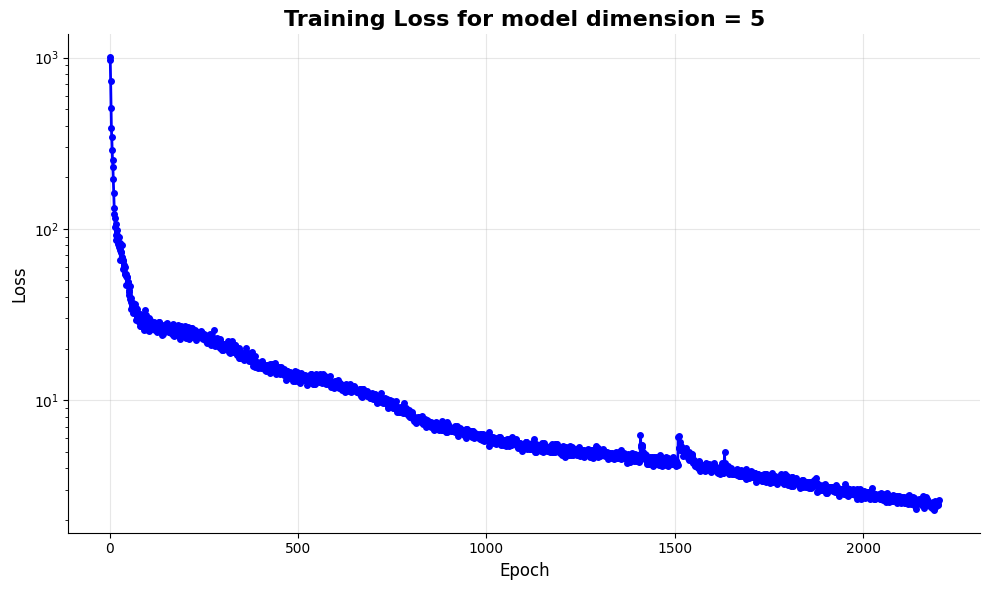

In [656]:
plot_loss(average_losses)

In [673]:
average_losses_10, trained_model_10 = train_model(10,5)

Adjusted batch size for Mac GPU: 10
Epoch [1/2200], Batch [20/30] Avg Loss: 1008.1499
Epoch [1/2200] completed. Average Loss:  1001.2496
Epoch [2/2200], Batch [20/30] Avg Loss: 848.6361
Epoch [2/2200] completed. Average Loss:  744.0024
Epoch [3/2200], Batch [20/30] Avg Loss: 345.8041
Epoch [3/2200] completed. Average Loss:  312.2344
Epoch [4/2200], Batch [20/30] Avg Loss: 176.9267
Epoch [4/2200] completed. Average Loss:  164.4439
Epoch [5/2200], Batch [20/30] Avg Loss: 120.8946
Epoch [5/2200] completed. Average Loss:  119.1098
Epoch [6/2200], Batch [20/30] Avg Loss: 96.8349
Epoch [6/2200] completed. Average Loss:  91.6029
Epoch [7/2200], Batch [20/30] Avg Loss: 76.0130
Epoch [7/2200] completed. Average Loss:  74.0919
Epoch [8/2200], Batch [20/30] Avg Loss: 51.6356
Epoch [8/2200] completed. Average Loss:  56.1554
Epoch [9/2200], Batch [20/30] Avg Loss: 48.8727
Epoch [9/2200] completed. Average Loss:  50.7245
Epoch [10/2200], Batch [20/30] Avg Loss: 57.4869
Epoch [10/2200] completed. Ave

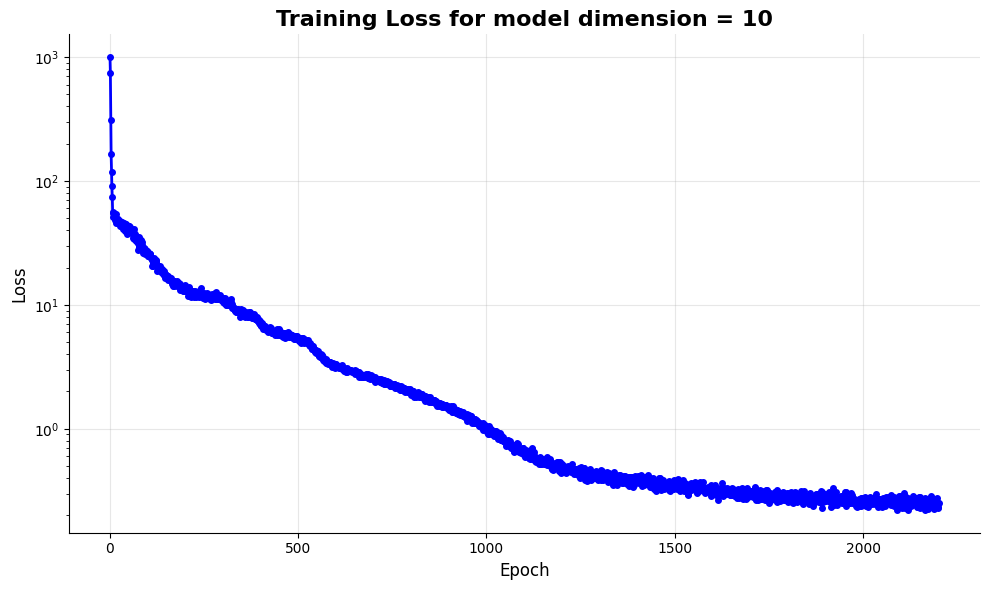

In [674]:
plot_loss(average_losses_10,title="Training Loss",d_model=10)

In [678]:
average_losses_10_10, trained_model_10_10 = train_model(10,10)

Adjusted batch size for Mac GPU: 10
Epoch [1/2200], Batch [20/30] Avg Loss: 1012.3771
Epoch [1/2200] completed. Average Loss:  1018.8429
Epoch [2/2200], Batch [20/30] Avg Loss: 839.2560
Epoch [2/2200] completed. Average Loss:  785.3435
Epoch [3/2200], Batch [20/30] Avg Loss: 540.2895
Epoch [3/2200] completed. Average Loss:  494.8778
Epoch [4/2200], Batch [20/30] Avg Loss: 352.5079
Epoch [4/2200] completed. Average Loss:  324.6376
Epoch [5/2200], Batch [20/30] Avg Loss: 240.3256
Epoch [5/2200] completed. Average Loss:  225.1908
Epoch [6/2200], Batch [20/30] Avg Loss: 156.1161
Epoch [6/2200] completed. Average Loss:  145.0987
Epoch [7/2200], Batch [20/30] Avg Loss: 111.8512
Epoch [7/2200] completed. Average Loss:  118.8915
Epoch [8/2200], Batch [20/30] Avg Loss: 107.5005
Epoch [8/2200] completed. Average Loss:  97.9364
Epoch [9/2200], Batch [20/30] Avg Loss: 61.0434
Epoch [9/2200] completed. Average Loss:  57.5861
Epoch [10/2200], Batch [20/30] Avg Loss: 50.5487
Epoch [10/2200] completed

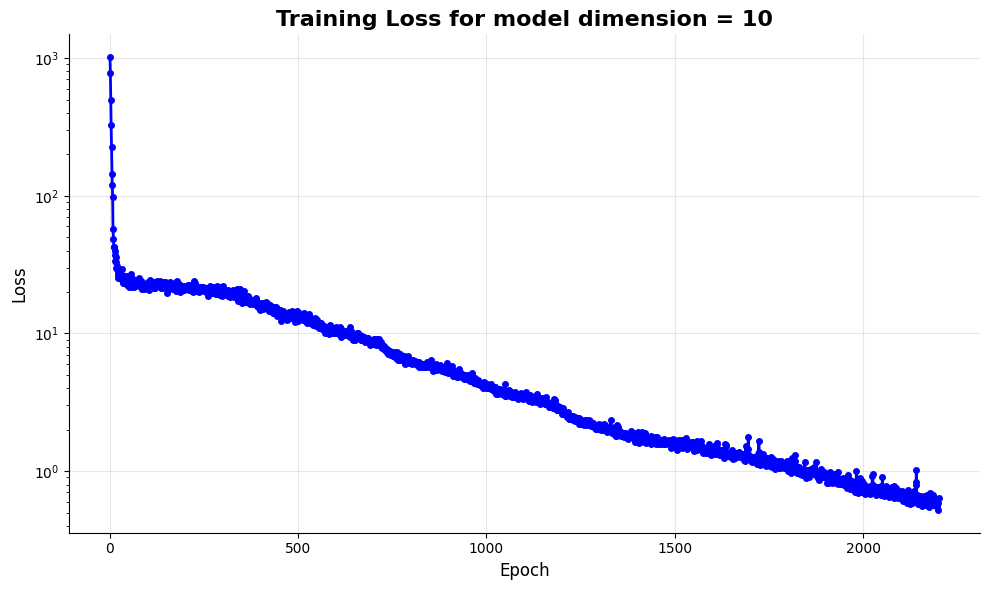

In [680]:
plot_loss(average_losses_10_10,title="Training Loss",d_model=10)

In [677]:
average_losses_15, trained_model_15 = train_model(15,6)

Adjusted batch size for Mac GPU: 10
Epoch [1/2200], Batch [20/30] Avg Loss: 1013.7663
Epoch [1/2200] completed. Average Loss:  984.7202
Epoch [2/2200], Batch [20/30] Avg Loss: 777.9679
Epoch [2/2200] completed. Average Loss:  703.0875
Epoch [3/2200], Batch [20/30] Avg Loss: 461.2853
Epoch [3/2200] completed. Average Loss:  437.0848
Epoch [4/2200], Batch [20/30] Avg Loss: 318.8831
Epoch [4/2200] completed. Average Loss:  312.6486
Epoch [5/2200], Batch [20/30] Avg Loss: 205.8687
Epoch [5/2200] completed. Average Loss:  195.8097
Epoch [6/2200], Batch [20/30] Avg Loss: 171.8218
Epoch [6/2200] completed. Average Loss:  164.0712
Epoch [7/2200], Batch [20/30] Avg Loss: 126.3026
Epoch [7/2200] completed. Average Loss:  129.2258
Epoch [8/2200], Batch [20/30] Avg Loss: 118.5386
Epoch [8/2200] completed. Average Loss:  122.6057
Epoch [9/2200], Batch [20/30] Avg Loss: 90.9913
Epoch [9/2200] completed. Average Loss:  95.5431
Epoch [10/2200], Batch [20/30] Avg Loss: 88.9819
Epoch [10/2200] completed

In [681]:
average_losses_5_10, trained_model_5_10 = train_model(5,10)

Adjusted batch size for Mac GPU: 10
Epoch [1/2200], Batch [20/30] Avg Loss: 1042.0445
Epoch [1/2200] completed. Average Loss:  1039.7652
Epoch [2/2200], Batch [20/30] Avg Loss: 983.1683
Epoch [2/2200] completed. Average Loss:  953.7584
Epoch [3/2200], Batch [20/30] Avg Loss: 831.7996
Epoch [3/2200] completed. Average Loss:  777.5914
Epoch [4/2200], Batch [20/30] Avg Loss: 667.5373
Epoch [4/2200] completed. Average Loss:  635.5087
Epoch [5/2200], Batch [20/30] Avg Loss: 476.8772
Epoch [5/2200] completed. Average Loss:  463.8537
Epoch [6/2200], Batch [20/30] Avg Loss: 375.3464
Epoch [6/2200] completed. Average Loss:  366.1702
Epoch [7/2200], Batch [20/30] Avg Loss: 344.0557
Epoch [7/2200] completed. Average Loss:  328.1028
Epoch [8/2200], Batch [20/30] Avg Loss: 270.2338
Epoch [8/2200] completed. Average Loss:  264.4843
Epoch [9/2200], Batch [20/30] Avg Loss: 221.7092
Epoch [9/2200] completed. Average Loss:  228.7590
Epoch [10/2200], Batch [20/30] Avg Loss: 207.6457
Epoch [10/2200] compl